# Ground Motion data from WFS
## This Notebook shows how the Ground Motion data can be loaded from the EODC WFS and how to visualize it.

### Import libraries

In [10]:
import os
import geopandas as gpd
import contextily as cx
from owslib.ogcapi.features import Features
from rich.console import Console

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import matplotlib.dates as mdates


### Load the WFS and create a feature collection with all available features

In [11]:
console = Console()

EODC_OGCAPI_URL = 'https://features.services.eodc.eu/'
eodc_ogcapi = Features(EODC_OGCAPI_URL)
console.print(eodc_ogcapi)

#collections = eodc_ogcapi.collections()
#console.print(collections)

feature_collections = eodc_ogcapi.feature_collections()
console.print(feature_collections)

# queryables = eodc_ogcapi.collection_queryables('Vlbg_EGMS_L3_U')
# console.print(queryables)

<owslib.ogcapi.features.Features object at 0x0000026F0309E610>

['adriatic_vessels', 'Vlbg_EGMS_L3_E', 'Vlbg_EGMS_L3_U', 'STATISTIK_AUSTRIA_DSR']

### Filter the data by spatial extent and create a geodataframe the with filtered data with north/south motion

In [12]:
bbox = [9.7549833,47.4537861,9.7616428,47.4581097]

field_items = eodc_ogcapi.collection_items(
    "Vlbg_EGMS_L3_U",
    bbox = bbox,
    limit = 2000,
)
console.print(f"We found {len(field_items['features'])} items matching the query criteria.")

df = gpd.GeoDataFrame.from_features(field_items["features"], crs="EPSG:4326")


We found 24 items matching the query criteria.

### Sort the data by columns

In [13]:
df_sorted = df[sorted(df.columns)]
df_sorted.head()

,20160105,20160111,20160117,20160123,20160129,20160204,20160210,20160216,20160222,20160228,...,geometry,height,layer,mean_vel_1,mean_veloc,northing,path,rmse,seasonal_1,seasonalit
0,1.3,0.6,0.5,0.8,1.2,0.9,1.3,2.1,2.1,2.1,...,POINT (9.75550 47.45429),418.8,Zusammengefasster Layer,0.1,-4.2,2704550,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",1.5,0.1,1.5
1,1.2,1.3,-0.6,-1.8,-0.9,0.4,1.7,2.5,2.0,1.7,...,POINT (9.75683 47.45429),417.3,Zusammengefasster Layer,0.1,-5.1,2704550,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",1.7,0.1,1.4
2,2.7,0.6,2.8,1.4,-2.2,-2.3,-0.4,2.2,4.8,6.7,...,POINT (9.75816 47.45429),416.2,Zusammengefasster Layer,0.1,-9.3,2704550,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",3.1,0.2,2.7
3,4.2,4.9,4.6,1.9,-1.8,-2.3,0.0,1.5,0.7,-0.7,...,POINT (9.75948 47.45429),415.9,Zusammengefasster Layer,0.1,-8.3,2704550,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",3.6,0.2,2.1
4,1.4,1.2,0.7,0.0,-1.0,-0.8,0.7,1.4,1.7,2.1,...,POINT (9.76081 47.45430),413.2,Zusammengefasster Layer,0.0,-6.1,2704550,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",1.1,0.1,1.7


### Plot the points on a basemap

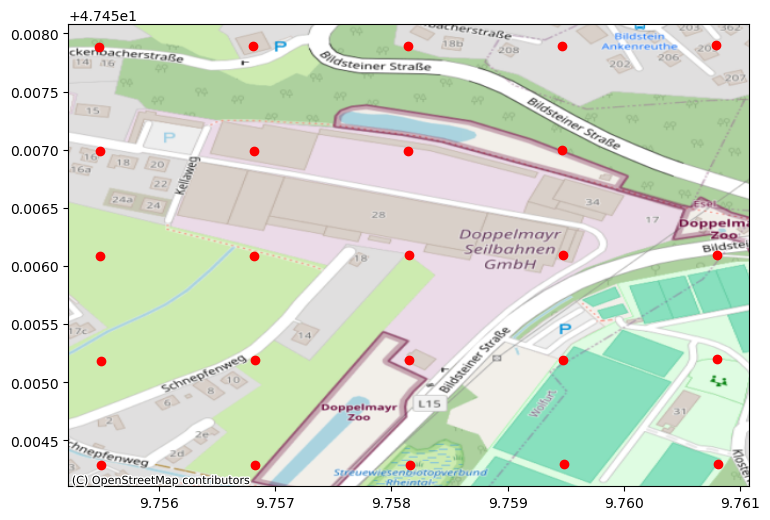

In [14]:

ax = df[["geometry"]].plot(
    facecolor="red", figsize=(12, 6)
)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik);


### Create a NumPy Array and create datetime objects from the columnnames

In [15]:
df_np = df_sorted.to_numpy()
columns_names=list(df_sorted)
acquisition_dates = columns_names[0:363]
#print(acquisition_dates)

acquisition_date_str = [f"{d[:4]}-{d[4:6]}-{d[6:8]}" for d in acquisition_dates]
acquisition_date_num = [datetime.strptime(d, "%Y-%m-%d") for d in acquisition_date_str]
#print(acquisition_date_num)

### The motion of each point plotted in a diagram

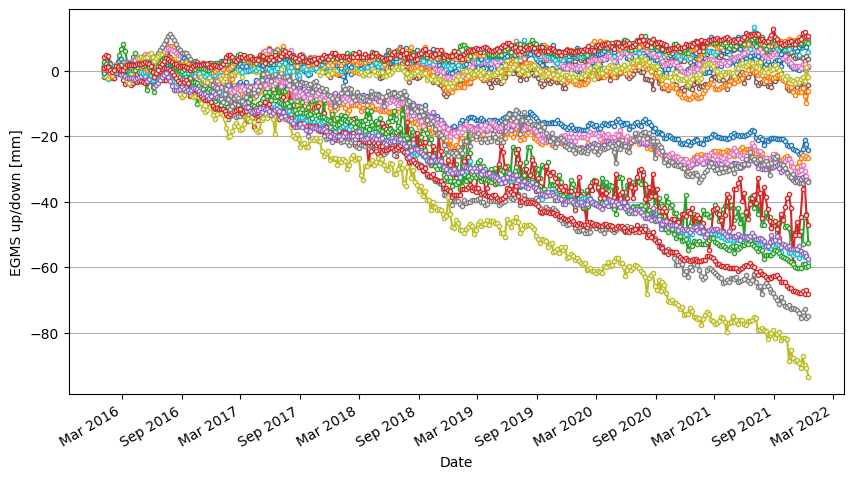

In [16]:
fig_EGMS_timeseries, axes = plt.subplots(nrows=1, ncols=1,facecolor='white', figsize=[10, 5])

for i in range(len(df_np)):
    axes.plot(acquisition_date_num,df_np[i,0:363], ".-", markerfacecolor="w")

axes.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(axes.get_xticklabels(), rotation=30, ha="right")
axes.set_xlabel('Date')
axes.set_ylabel('EGMS up/down [mm]')
axes.grid(visible=True,axis='y')
